In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk                    
import string
import re
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [4]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [5]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [6]:
# Check the data
data.head()

,title,text,subject,date,target
0,BRITISH ACTRESS NAILS IT: Do you think ISIS ca...,Pathetic Predictably impotent. We are not unit...,politics,"Jul 15, 2016",fake
1,"Two Weeks Before Election, Trump Still Defend...","Sunday morning, after what must have seemed li...",News,"November 26, 2017",fake
2,Asian viewers give nod to Clinton after first ...,BEIJING/TOKYO (Reuters) - Hillary Clinton put ...,politicsNews,"September 27, 2016",true
3,U.S. top diplomat to visit Asia as part of Tru...,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,"November 2, 2017",true
4,UK PM May concerned by reports of sexual haras...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"October 27, 2017",true


In [7]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,BRITISH ACTRESS NAILS IT: Do you think ISIS ca...,Pathetic Predictably impotent. We are not unit...,politics,fake
1,"Two Weeks Before Election, Trump Still Defend...","Sunday morning, after what must have seemed li...",News,fake
2,Asian viewers give nod to Clinton after first ...,BEIJING/TOKYO (Reuters) - Hillary Clinton put ...,politicsNews,true
3,U.S. top diplomat to visit Asia as part of Tru...,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,true
4,UK PM May concerned by reports of sexual haras...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,true


In [8]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Pathetic Predictably impotent. We are not unit...,politics,fake
1,"Sunday morning, after what must have seemed li...",News,fake
2,BEIJING/TOKYO (Reuters) - Hillary Clinton put ...,politicsNews,true
3,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,true
4,LONDON (Reuters) - British Prime Minister Ther...,worldnews,true


In [9]:
data['target_num'] = data['target'].map(lambda x: 1 if x == "true" else 0)

In [10]:
data.head()

,text,subject,target,target_num
0,Pathetic Predictably impotent. We are not unit...,politics,fake,0
1,"Sunday morning, after what must have seemed li...",News,fake,0
2,BEIJING/TOKYO (Reuters) - Hillary Clinton put ...,politicsNews,true,1
3,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,true,1
4,LONDON (Reuters) - British Prime Minister Ther...,worldnews,true,1


C:\Users\Prithvi Raj Yadav\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


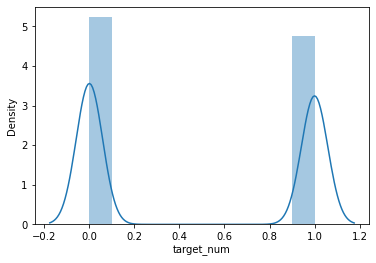

In [11]:
sns.distplot(data['target_num'],bins=10)
plt.show()

# 1) Text Preprocessing

## (i) HTML Tag Removal

In [12]:
import re
# cleaning html symbols from the sentence
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

## (ii) Punctuations Removal

In [13]:
# cleaning punctuations from the sentence
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

## (iiI) Stopwords

* A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = stopwords.words('english') #All the stopwords in English language
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

[nltk_data] Downloading package stopwords to C:\Users\Prithvi Raj
[nltk_data]     Yadav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## (iv) Stemming

* A word stem is part of a word. It is sort of a normalization idea, but linguistic.
For example, the stem of the word waiting is wait.

In [15]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer

In [16]:
print(snow.stem('Secretary')) #same meaning word with different spellings

secretari


# PreProcessing on all the news

In [17]:
i = 0
string1 = ' '
final_string = []
fake_words = []                
real_words = []
s = ''

for sent in data['text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    sent = cleanpunc(sent)
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):  
            if(w.lower() not in stop):    # If it is a stopword
                s = (snow.stem(w.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (data['target'].values)[i] == 'true':
                    real_words.append(s)
                if(data['target'].values)[i] == 'fake':
                    fake_words.append(s)
            else:
                continue
        else:
            continue 
    string1 = b" ".join(filtered_sentence) 
    final_string.append(string1)
    i += 1

# Fake and Real words in text

In [18]:
from collections import Counter
print("Number of Real words: ", len(real_words))
print("Number of Fake words: ", len(fake_words))

Number of Real words:  4654616
Number of Fake words:  5337297


In [19]:
data['CleanedText'] = final_string
data.head()

,text,subject,target,target_num,CleanedText
0,Pathetic Predictably impotent. We are not unit...,politics,fake,0,b'pathet predict impot not unit divid not stan...
1,"Sunday morning, after what must have seemed li...",News,fake,0,b'sunday morn must seem like anoth intermin we...
2,BEIJING/TOKYO (Reuters) - Hillary Clinton put ...,politicsNews,true,1,b'beij tokyo reuter hillari clinton put donald...
3,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,true,1,b'washington reuter secretari state rex tiller...
4,LONDON (Reuters) - British Prime Minister Ther...,worldnews,true,1,b'london reuter british prime minist theresa m...


In [20]:
# without stem
i = 0
string1 = ' '
final_string_nostem = []
s = ''

for sent in data['text'].values:
    filtered_sentence=[]
    sent = cleanhtml(sent)
    sent = cleanpunc(sent)
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):  
            if(w.lower() not in stop):
                s = w.lower().encode('utf8')
                filtered_sentence.append(s)
            else:
                continue
        else:
            continue 
    string1 = b" ".join(filtered_sentence)     
    final_string_nostem.append(string1)
    i += 1

In [21]:
data['CleanedText_NoStem'] = final_string_nostem

In [22]:
data.head(10)

,text,subject,target,target_num,CleanedText,CleanedText_NoStem
0,Pathetic Predictably impotent. We are not unit...,politics,fake,0,b'pathet predict impot not unit divid not stan...,b'pathetic predictably impotent not united div...
1,"Sunday morning, after what must have seemed li...",News,fake,0,b'sunday morn must seem like anoth intermin we...,b'sunday morning must seemed like another inte...
2,BEIJING/TOKYO (Reuters) - Hillary Clinton put ...,politicsNews,true,1,b'beij tokyo reuter hillari clinton put donald...,b'beijing tokyo reuters hillary clinton put do...
3,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,true,1,b'washington reuter secretari state rex tiller...,b'washington reuters secretary state rex tille...
4,LONDON (Reuters) - British Prime Minister Ther...,worldnews,true,1,b'london reuter british prime minist theresa m...,b'london reuters british prime minister theres...
5,"Republicans are beginning to jump ship, and ar...",News,fake,0,b'republican begin jump ship becom member grow...,b'republicans beginning jump ship becoming mem...
6,There s nothing odd about Donald Trump getting...,News,fake,0,b'noth odd donald trump get blast day day medi...,b'nothing odd donald trump getting blasted day...
7,Kellyanne Conway defends Trump s Hamilton tw...,left-news,fake,0,b'kellyann conway defend trump hamilton twitte...,b'kellyanne conway defends trump hamilton twit...
8,GOP presidential candidate John Kasich would l...,News,fake,0,b'gop presidenti candid john kasich would like...,b'gop presidential candidate john kasich would...
9,BAKU (Reuters) - Turkey s foreign minister cal...,worldnews,true,1,b'baku reuter turkey foreign minist call wedne...,b'baku reuters turkey foreign minister called ...


# Convert words to vector

## Using Google's Trained W2Vec

In [23]:
from gensim.models import KeyedVectors
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
w2v_model_google = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

C:\Users\Prithvi Raj Yadav\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [24]:
w2v_model_google.most_similar('Secretary')


[('secretary', 0.7287614941596985),
 ('Assistant_Secretary', 0.7153509855270386),
 ('Undersecretary', 0.7121137380599976),
 ('Secre_tary', 0.6972907185554504),
 ('Secretery', 0.6963104009628296),
 ('Secreatry', 0.6765152812004089),
 ('ecretary', 0.671087384223938),
 ('Secretaries', 0.6705101728439331),
 ('Sectretary', 0.664540708065033),
 ('Sectary', 0.6633391976356506)]

In [25]:
w2v_model_google["word"].size

300

In [26]:
import random
avg_vec_google = []
datapoint = 3000
sample_cols = random.sample(range(1, datapoint), 1001)

for sent in data['CleanedText_NoStem'].values[sample_cols]:
    cnt = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
            wvec = w2v_model_google[word]
            sent_vec += wvec
            cnt += 1
        except: 
            pass
    sent_vec /= cnt
    avg_vec_google.append(sent_vec)
avg_vec_google = np.array(avg_vec_google)

<ipython-input-26-3d855886a6d0>:17: RuntimeWarning: invalid value encountered in true_divide
  sent_vec /= cnt


In [27]:
np.any(np.isnan(avg_vec_google))

True

In [28]:
np.all(np.isfinite(avg_vec_google))

False

In [29]:
col_mean = np.nanmean(avg_vec_google, axis=0)

In [30]:
inds = np.where(np.isnan(avg_vec_google)) 
inds


(array([ 47,  47,  47, ..., 841, 841, 841], dtype=int64),
 array([  0,   1,   2, ..., 297, 298, 299], dtype=int64))

In [31]:
avg_vec_google[inds] = np.take(col_mean, inds[1])

In [32]:
avg_vec_google

array([[ 0.01785706,  0.01681891,  0.02592214, ..., -0.0225651 ,
         0.03590844, -0.01415958],
       [ 0.02139811,  0.01950536, -0.0031975 , ..., -0.03270904,
        -0.00535581,  0.01412288],
       [ 0.03409165,  0.04696877,  0.02103865, ..., -0.03870366,
         0.00767943, -0.00171152],
       ...,
       [ 0.02186043,  0.01393979,  0.05591919, ..., -0.05780183,
         0.04444424,  0.02680237],
       [ 0.04348733,  0.05389517,  0.0731332 , ..., -0.04236516,
         0.07637291, -0.01621249],
       [-0.01733771,  0.07357532,  0.04701016, ..., -0.01302529,
         0.04008912, -0.0053652 ]])

In [33]:
from sklearn import preprocessing
avg_vec_google_norm = preprocessing.normalize(avg_vec_google)

## Visualizing using TSNE

<ipython-input-34-cf7e5d92454b>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sample_class = sample_class[:,np.newaxis]
C:\Users\Prithvi Raj Yadav\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


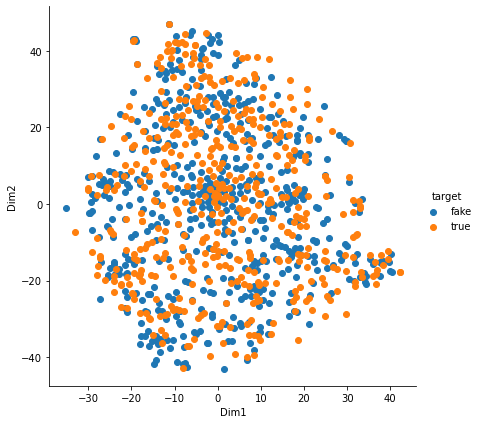

In [34]:
# Perplexity = 20

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, avg_vec_google.shape[0]), n_samples)
sample_features = avg_vec_google[sample_cols]

sample_class = data['target'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=20)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","target"])

sns.FacetGrid(tsne_data,hue="target",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

<ipython-input-35-df0b417dc493>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sample_class = sample_class[:,np.newaxis]
C:\Users\Prithvi Raj Yadav\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


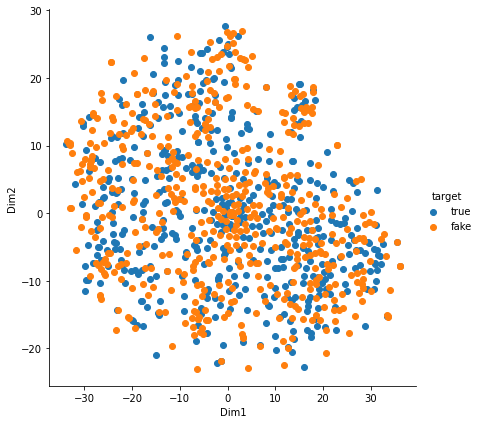

In [35]:
# Perplexity = 30

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, avg_vec_google.shape[0]), n_samples)
sample_features = avg_vec_google[sample_cols]

sample_class = data['target'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=30)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","target"])

sns.FacetGrid(tsne_data,hue="target",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

<ipython-input-36-d4c0d65dbc93>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sample_class = sample_class[:,np.newaxis]
C:\Users\Prithvi Raj Yadav\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


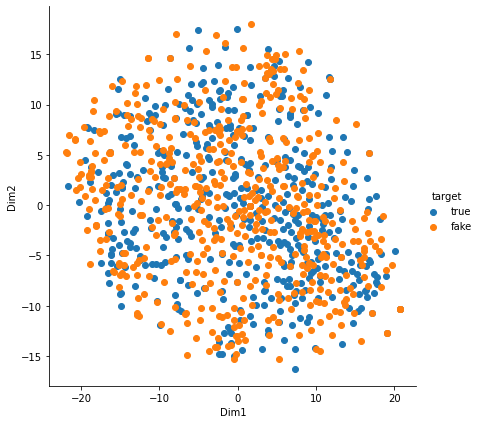

In [36]:
# Perplexity = 50

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, avg_vec_google.shape[0]), n_samples)
sample_features = avg_vec_google[sample_cols]

sample_class = data['target'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=50)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","target"])

sns.FacetGrid(tsne_data,hue="target",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

<ipython-input-37-89b45602513e>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sample_class = sample_class[:,np.newaxis]
C:\Users\Prithvi Raj Yadav\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


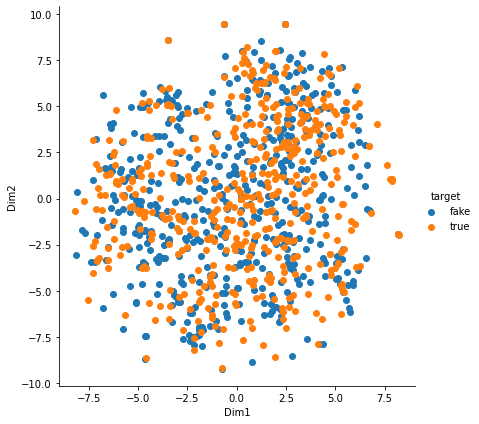

In [37]:
# Perplexity = 100

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, avg_vec_google.shape[0]), n_samples)
sample_features = avg_vec_google[sample_cols]

sample_class = data['target'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=100)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","target"])

sns.FacetGrid(tsne_data,hue="target",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

<ipython-input-38-60348ad45e07>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sample_class = sample_class[:,np.newaxis]
C:\Users\Prithvi Raj Yadav\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


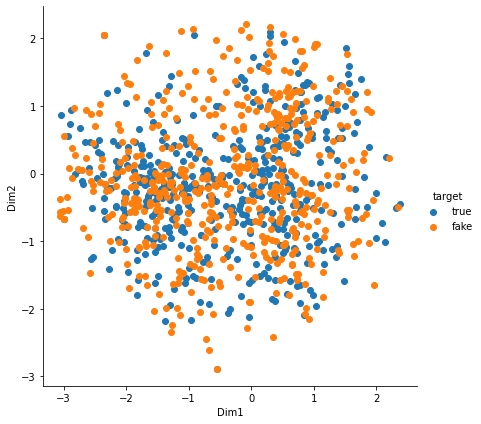

In [38]:
# Perplexity = 500

from sklearn.manifold import TSNE
import random

n_samples = 1000
sample_cols = random.sample(range(1, avg_vec_google.shape[0]), n_samples)
sample_features = avg_vec_google[sample_cols]

sample_class = data['target'][sample_cols]
sample_class = sample_class[:,np.newaxis]
model = TSNE(n_components=2,random_state=0,perplexity=500)

embedded_data = model.fit_transform(sample_features)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
tsne_data = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","target"])

sns.FacetGrid(tsne_data,hue="target",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

### Observation:-
* We can say that there is less overlapping fake and real news points in the graph.
* Therefore Average Word2Vec will give the best classifying the news as fake or real.

# Avg Word2vec

* word2vec is an algorithm for constructing vector representations of words, also known as word embeddings. The vector for each word is a semantic description of how that word is used in context, so two words that are used similarly in text will get similar vector represenations. Once you map words into vector space, you can then use vector math to find words that have similar semantics.

In [39]:
from sklearn.base import TransformerMixin, BaseEstimator
from gensim.models import Word2Vec
class w2v(TransformerMixin, BaseEstimator):

    def __init__(self, vector_size=100, alpha=0.025, window=5, min_count=10, max_vocab_size=None, sample=1e-3, seed=1,
                 workers=3, min_alpha=0.0001, sg=1, hs=0, negative=5, cbow_mean=1, hashfxn=hash, epochs=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000):
        """
        Sklearn wrapper for Word2Vec model. See gensim.models.Word2Vec for parameter details.
        """
        self.model = None
        self.vector_size = vector_size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.cbow_mean = int(cbow_mean)
        self.hashfxn = hashfxn
        self.epochs = epochs
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words

    def fit(self, X, y=None):
        """
        Fit the model according to the given training data.
        Calls gensim.models.Word2Vec
        """
        X_tokenized = X.apply(lambda sent: sent.split())
        
        self.model = Word2Vec(
            sentences=X_tokenized, vector_size=self.vector_size, alpha=self.alpha,
            window=self.window, min_count=self.min_count, max_vocab_size=self.max_vocab_size,
            sample=self.sample, seed=self.seed, workers=self.workers, min_alpha=self.min_alpha,
            sg=self.sg, hs=self.hs, negative=self.negative, cbow_mean=self.cbow_mean, 
            hashfxn=self.hashfxn, epochs=self.epochs, null_word=self.null_word, trim_rule=self.trim_rule,
            sorted_vocab=self.sorted_vocab, batch_words=self.batch_words
        )
        return self

    def transform(self, X):
        return X.apply(self.avg_word_vector)
    
    def avg_word_vector(self, sent):
        """
        Returns an average word vector 
        from list of words
        if words are not in the wordvector
        vocabulary or in wordlist is 
        empty then returns a zero vector
        """
        word_list = sent.split()
        sent_vec = np.zeros(self.vector_size)
        word_cnt = 0
        for word in word_list:
            try:
                vec = self.model.wv[word]
                sent_vec += vec
                word_cnt += 1
            except KeyError:
                pass
        if word_cnt != 0:
            sent_vec /= word_cnt
        return pd.Series(sent_vec)
    
    def most_similar(self, word):
        return self.model.wv.most_similar(word)
    
    def vocabulary(self):
        """
        Returns a Dataframe with 
        word as index and rows as vectors
        """
        # build a list of the terms, integer indices,
        # and term counts from the word2vec model vocabulary
        ordered_vocab = [(term, voc.index, voc.count)
                         for term, voc in self.model.wv.vocab.items()]

        # sort by the term counts, so the most common terms appear first
        ordered_vocab = sorted(ordered_vocab, key=lambda k : k[2], reverse=True)

        # unzip the terms, integer indices, and counts into separate lists
        ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

        # create a DataFrame with the word vectors as data,
        # and the terms as row labels
        wordvectors = pd.DataFrame(self.model.wv.vectors_norm[term_indices, :],
                                    index=ordered_terms)

        return wordvectors

In [40]:
w2v_model = w2v()
w2v_features = w2v_model.fit_transform(data['text'])
w2v_features.shape

(44898, 100)

In [41]:
# from sklearn import preprocessing
avg_w2v_norm = preprocessing.normalize(w2v_features)

# Applying Classification Techniques

In [42]:
# spliting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(avg_w2v_norm,data['target'],
                                                   test_size=0.3, shuffle=False)

# K Nearest Neighbor

In [55]:
# loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [45]:
# 1. Instantiating the 'estimator'
knn = KNeighborsClassifier(n_neighbors = 5)

# 2. fit the model with data, aka 'model training'
knn.fit(X_train, y_train)

# 3. Predict the response for observations being passed, here 'X-test'
y_pred = knn.predict(X_test)

# getting the testing accuracy of KNN (K=5)
print (metrics.accuracy_score(y_test, y_pred))

0.9749072011878248


# Using different values for 'K' in KNN
for the case k = 5 we got , accuracy = 97.49%, trying k values from 1 to 25, we get ...

In [48]:
k_range = range(1, 26)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Accuracy')

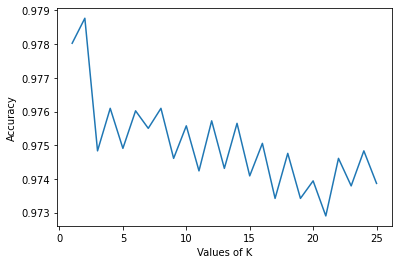

In [49]:
import matplotlib.pyplot as plt

# for plotting the graph inside the notebook itself
%matplotlib inline

plt.plot(k_range, scores)
plt.xlabel('Values of K')
plt.ylabel('Accuracy')

## Naive Bayes

In [85]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [86]:
y_pred = clf.predict(X_test)

print('Accuracy on test set:', accuracy_score(y_test, y_pred))
print('\n                    Classification Report')
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.922077922077922

                    Classification Report
              precision    recall  f1-score   support

        fake       0.93      0.91      0.92       262
        true       0.92      0.94      0.93       277

    accuracy                           0.92       539
   macro avg       0.92      0.92      0.92       539
weighted avg       0.92      0.92      0.92       539



# Estimators

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [71]:
from sklearn.model_selection import GridSearchCV

def search_param(clf, param_grid, X, y, test_size=0.3, cv=10, n_jobs=-1,
                 random_search=False, n_iter=10, return_train_score=False):
    """
    Splits the data using time based slicing
    Performs grid search to search for optimal parameter
    using exaustive or random search
    Print accuracy and classification report with
    best parameter on test set
    """
    
    # time based splitting of dataset
    X_train, X_test, y_train, y_test = train_test_split_by_time(X, y, test_size)
    
    if random_search:
        grid_search = RandomizedSearchCV(clf, param_grid, n_iter=n_iter, 
                                         n_jobs=n_jobs, verbose=1, cv=cv, 
                                         return_train_score=return_train_score)
    else:
        grid_search = GridSearchCV(clf, param_grid, n_jobs=n_jobs, 
                                   verbose=1, cv=cv, 
                                   return_train_score=return_train_score)
    
    print('Performing grid search...\n')
    print('Parameters:')
    print(param_grid)
    print()
    
    grid_search.fit(X_train, y_train)
    print('\n')
    
    print("Best CV score: %f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("\nTest score with best_estimator_: %f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("                 Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    
    return grid_search

In [73]:
def train_test_split_by_time(X, y, test_ratio = 0.3):
    """
    y parameter needs to be a pandas series
    with timestamp as its index
    """
    
    train_ratio = 1 - test_ratio
    train_end = int(train_ratio * len(y))
    
    sorted_index = y.index.argsort()
    train_index = sorted_index[:train_end]
    test_index = sorted_index[train_end:]
    
    try:
        return X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]
    except KeyError:
        # if X is a pandas data structure
        return X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

In [74]:
class power_uniform():
    def __init__(self, low=0.0, high=1.0, base=10.0):
        self.low = low
        self.high = high
        self.base = base

    def rvs(self, random_state):
        return self.base ** np.random.uniform(self.low, self.high)

# Support Vector Machine Classifier

In [78]:
from sklearn.svm import SVC
X_sample, X_sam, y_sample, y_sam = train_test_split(w2v_features, data['target'], train_size=0.04)

In [79]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split_by_time(X_sample, y_sample)

In [80]:
# Train model with default hyperparameter
clf = SVC()
clf.fit(X_train, y_train)

print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.974025974025974


In [81]:
# Column standardization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([('Scalar', StandardScaler(with_mean=False)),
               ('svc', SVC())])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.9795918367346939


In [82]:
# Using Random search
param_grid = {
    'svc__C': power_uniform(-4, 4),
    'svc__gamma': power_uniform(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('svc', SVC())
])

best_svm = search_param(clf, param_grid, X_sample, y_sample, random_search=True, n_iter=20)

Performing grid search...

Parameters:
{'svc__C': <__main__.power_uniform object at 0x000002C1CF646400>, 'svc__gamma': <__main__.power_uniform object at 0x000002C1CF646670>}

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.3s finished




Best CV score: 0.992825
Best parameters set:
	svc__C: 807.3627820221791
	svc__gamma: 1.0523547518825165

Test score with best_estimator_: 0.985158


                 Classification Report Test Data
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98       262
        true       0.99      0.99      0.99       277

    accuracy                           0.99       539
   macro avg       0.99      0.99      0.99       539
weighted avg       0.99      0.99      0.99       539



In [83]:
# Using Grid search
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
param_grid = {
    'svc__C': 10.0 ** np.arange(-4, 4),
    'svc__gamma': 10.0 ** np.arange(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('svc', SVC())
])

best_svm = search_param(clf, param_grid, X_sample, y_sample)

Performing grid search...

Parameters:
{'svc__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'svc__gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:   11.8s




Best CV score: 0.993619
Best parameters set:
	svc__C: 100.0
	svc__gamma: 1.0

Test score with best_estimator_: 0.985158


                 Classification Report Test Data
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98       262
        true       0.99      0.99      0.99       277

    accuracy                           0.99       539
   macro avg       0.99      0.99      0.99       539
weighted avg       0.99      0.99      0.99       539



[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   14.5s finished


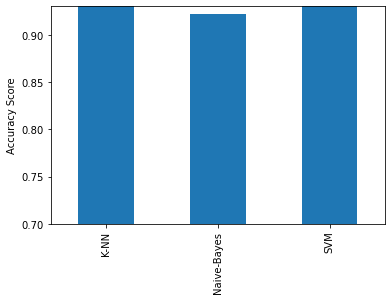

In [87]:
model_accuracy = {
    'K-NN': 0.9749,
    'Naive-Bayes': 0.9220,
    'SVM': 0.9851
}

pd.Series(model_accuracy).plot(kind='bar')
plt.ylabel('Accuracy Score')
plt.ylim((0.70, 0.93));